In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import warnings

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA, PLSCanonical

rs_num = 14
rng = np.random.default_rng(rs_num)

sklearn.set_config(display="diagram")

# 1. Dataset Construction

In [2]:
sample_num = 300
X_dimension_num = 4
Y_dimension_num = 3

# construct X
x1 = rng.normal(loc=0.0, scale=1.0, size=(sample_num, 1))
x2 = rng.normal(loc=0.0, scale=1.0, size=(sample_num, 1))
x3 = rng.normal(loc=0.0, scale=1.0, size=(sample_num, 1))
x4 = rng.normal(loc=0.0, scale=1.0, size=(sample_num, 1))

X = np.zeros((sample_num, X_dimension_num))
X[:, 0] = x1.reshape(-1, )
X[:, 1] = x2.reshape(-1, )
X[:, 2] = x3.reshape(-1, )
X[:, 3] = x4.reshape(-1, )

# noise
xi_1 = rng.normal(loc=0, scale=np.sqrt(0.2), size=x3.shape)
xi_2 = rng.normal(loc=0, scale=np.sqrt(0.4), size=x1.shape)
xi_3 = rng.normal(loc=0, scale=np.sqrt(0.3), size=x4.shape)

# contruct Y
y1 = x3 + xi_1
y2 = x1 + xi_2
y3 = -x4 + xi_3

Y = np.zeros((sample_num, Y_dimension_num))
Y[:, 0] = y1.reshape(-1, )
Y[:, 1] = y2.reshape(-1, )
Y[:, 2] = y3.reshape(-1, )

Split the dataset into training and testing datasets:

In [3]:
[X_train, X_test, Y_train, Y_test] = train_test_split(X, Y, test_size=0.20, random_state=rs_num)

Standardize two matrices:

In [4]:
# standardization of two matrices
X_train_scaler = StandardScaler().fit(X_train)
X_train_standardized = X_train_scaler.transform(X_train)
X_test_standardized = X_train_scaler.transform(X_test)

Y_train_scaler = StandardScaler().fit(Y_train)
Y_train_standardized = Y_train_scaler.transform(Y_train)
Y_test_standardized = Y_train_scaler.transform(Y_test)

We can also get a baseline model evaluation through linear regression.

In [5]:
pipeline_baseline = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('lr', LinearRegression())
    ]
)

cv_scores_baseline = cross_validate(
    pipeline_baseline, X_train, Y_train, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
)['test_score']

# also train on the whole training dataset, and see the score on the test dataset
pipeline_baseline.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

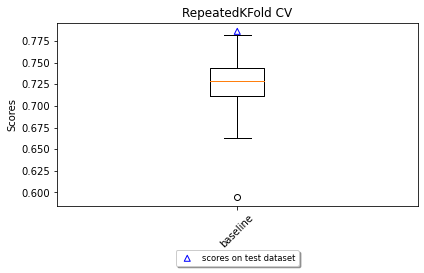

In [36]:
# visualize model evaluation
viz_labels = ['baseline']

fig, ax = plt.subplots()

ax.boxplot(
    [cv_scores_baseline], labels=viz_labels
)
ax.scatter(
    [1], 
    [pipeline_baseline.score(X_test, Y_test)], 
    fc='none',
    ec='blue', 
    marker='^', 
    label='scores on test dataset'
)

ax.set(ylabel='Scores', title='RepeatedKFold CV')
ax.set_xticklabels(viz_labels, rotation=45)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.22),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize='small'
)

plt.tight_layout()

# 2. CCA via sklearn CCA

In [7]:
# create a customized cross-validation method
def custom_cv(validator, X, Y, fit_n_score_func, *args):
    # note: normally X and Y are already training datasets
    
    # construct score array
    score_arr = np.zeros((validator.get_n_splits(), ))
    
    # fit and validate
    ii = 0
    for train_ind, test_ind in validator.split(X):
        # slicing arrays
        X_train, X_test = X[train_ind], X[test_ind]
        Y_train, Y_test = Y[train_ind], Y[test_ind]
        
        # train the model and get the score
        score_arr[ii] = fit_n_score_func(X_train, X_test, Y_train, Y_test, *args)
        ii += 1
    
    return score_arr

In [8]:
# create a customized pipeline
def sklearn_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components, max_iter, tol):
    # fitting the model
    cca = CCA(n_components=n_components, max_iter=max_iter, tol=tol).fit(X_train, Y_train)
    
    # transform the model
    Xc_train, Yc_train = cca.transform(X_train, Y_train)
    Xc_test, Yc_test = cca.transform(X_test, Y_test)
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [9]:
rkf_sklearn = RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
n_components = np.min([X_dimension_num, Y_dimension_num])
max_iter = int(1e12)
tol = 1e-12

In [11]:
# manuallly chain them together
cca_sklearn = CCA(
    n_components=n_components, 
    max_iter=max_iter, 
    tol=tol
).fit(X_train, Y_train)

# note: X and Y will be standardized
Xc_train_sklearn, Yc_train_sklearn = cca_sklearn.transform(X_train, Y_train)
Xc_test_sklearn, Yc_test_sklearn = cca_sklearn.transform(X_test, Y_test)

# calculate canonical correlation
cc_sklearn = np.corrcoef(
    Xc_train_sklearn.T, Yc_train_sklearn.T
).diagonal(offset=n_components)

# also compare if pre-standardization would make a difference
check_Xc_train_sklearn, check_Yc_train_sklearn = CCA(
    n_components=n_components, 
    max_iter=max_iter, 
    tol=tol
).fit_transform(X_train_standardized, Y_train_standardized)

print(
    'Pre-standardization makes {:.2e} total difference on X'.format(
        np.linalg.norm(check_Xc_train_sklearn-Xc_train_sklearn)
    )
)
print(
    'Pre-standardization makes {:.2e} total difference on Y'.format(
        np.linalg.norm(check_Yc_train_sklearn-Yc_train_sklearn)
    )
)

Pre-standardization makes 8.20e-14 total difference on X
Pre-standardization makes 8.18e-14 total difference on Y


Now we can similarly apply the same Linear Regression on the transformed datasets.

In [12]:
cv_scores_sklearn = custom_cv(
    rkf_sklearn, X_train, Y_train, 
    sklearn_cca_fit_n_score, 
    n_components, max_iter, tol
)

# also evaluate them manually
eval_score_sklearn = sklearn_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    n_components, max_iter, tol
)

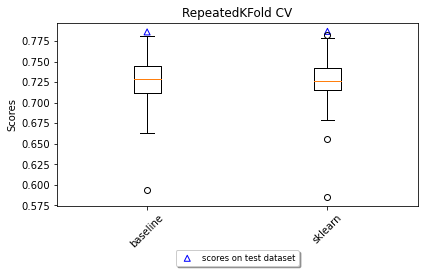

In [35]:
# visualize model evaluation
viz_labels = ['baseline', 'sklearn']

fig, ax = plt.subplots()

ax.boxplot(
    [cv_scores_baseline, cv_scores_sklearn], 
    labels=viz_labels
)
ax.scatter(
    [1, 2], 
    [pipeline_baseline.score(X_test, Y_test), eval_score_sklearn], 
    fc='none',
    ec='blue', 
    marker='^', 
    label='scores on test dataset'
)

ax.set(ylabel='Scores', title='RepeatedKFold CV')
ax.set_xticklabels(viz_labels, rotation=45)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.22),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize='small'
)

plt.tight_layout()

# 3. CCA via Standard Eigenvalue Problem

In [14]:
# compute joint covariance matrix
C = np.cov(X_train_standardized.T, Y_train_standardized.T, ddof=0)

Cxx = C[0:X_dimension_num, 0:X_dimension_num]
Cxy = C[0:X_dimension_num, X_dimension_num:]
Cyy = C[X_dimension_num:, X_dimension_num:]

C_compute = np.linalg.multi_dot(
    [np.linalg.inv(Cyy), Cxy.T, np.linalg.inv(Cxx), Cxy]
)

[eig_val, eig_vec] = np.linalg.eig(C_compute)

# Y matrix weights
wy = eig_vec

canonical_correlation_arr = np.sqrt(eig_val)
print('The canonical correlation is:')
print(canonical_correlation_arr)

wx = np.linalg.multi_dot([np.linalg.inv(Cxx), Cxy, wy])/canonical_correlation_arr

The canonical correlation is:
[0.91048651 0.80452823 0.86642529]


In [15]:
# sort by canonical correlation
cc_argind = canonical_correlation_arr.argsort()
cc_arr_sorted = canonical_correlation_arr[cc_argind[::-1]]
wx_sorted = wx[:, cc_argind[::-1]]
wy_sorted = wy[:, cc_argind[::-1]]

In [16]:
print('Canonical Correlation calculated by Standard Eigenvalue Problem:')
print(cc_arr_sorted)
print('')
print('Canonical Correlation calculated by sklearn CCA:')
print(cc_sklearn)

Canonical Correlation calculated by Standard Eigenvalue Problem:
[0.91048651 0.86642529 0.80452823]

Canonical Correlation calculated by sklearn CCA:
[0.91048651 0.86642529 0.80452823]


In [17]:
print('Weight vector w_x calculated by Standard Eigenvalue Problem:')
print(wx_sorted)
print('')
print('Weight vector w_x calculated by sklearn CCA:')
print(cca_sklearn.x_weights_)

Weight vector w_x calculated by Standard Eigenvalue Problem:
[[-0.10185969 -0.23970984  0.93366329]
 [ 0.04420503  0.01218802 -0.07242301]
 [-0.99097395  0.18065651 -0.14774114]
 [-0.09693603 -0.93487307 -0.3524133 ]]

Weight vector w_x calculated by sklearn CCA:
[[ 0.10166669  0.2512014   0.95903829]
 [-0.04412212 -0.01529023 -0.07699841]
 [ 0.98911949 -0.12042806 -0.07641433]
 [ 0.09674585  0.96029222 -0.26168234]]


In [18]:
print('Weight vector w_y calculated by Standard Eigenvalue Problem:')
print(wy_sorted)
print('')
print('Weight vector w_y calculated by sklearn CCA:')
print(cca_sklearn.y_weights_)

Weight vector w_y calculated by Standard Eigenvalue Problem:
[[-0.98695911  0.1985678  -0.18571926]
 [-0.11429969 -0.26796202  0.93281165]
 [ 0.11334591  0.9427445   0.3088216 ]]

Weight vector w_y calculated by sklearn CCA:
[[ 0.98696035 -0.14106983 -0.077515  ]
 [ 0.11429728  0.27512491  0.95459018]
 [-0.11333757 -0.95100241  0.28766127]]


Now we can see how well this method handles the datasets.

In [22]:
# create a customized pipeline
def std_eig_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components):
    X_dimension_num = X_train.shape[1]
    
    # standardization of two matrices
    X_train_scaler = StandardScaler().fit(X_train)
    X_train_standardized = X_train_scaler.transform(X_train)
    X_test_standardized = X_train_scaler.transform(X_test)

    Y_train_scaler = StandardScaler().fit(Y_train)
    Y_train_standardized = Y_train_scaler.transform(Y_train)
    Y_test_standardized = Y_train_scaler.transform(Y_test)
    
    # compute joint covariance matrix
    C = np.cov(X_train_standardized.T, Y_train_standardized.T, ddof=0)

    Cxx = C[0:X_dimension_num, 0:X_dimension_num]
    Cxy = C[0:X_dimension_num, X_dimension_num:]
    Cyy = C[X_dimension_num:, X_dimension_num:]

    C_compute = np.linalg.multi_dot(
        [np.linalg.inv(Cyy), Cxy.T, np.linalg.inv(Cxx), Cxy]
    )
    
    # solve standard eigenvalue problem
    [eig_val, eig_vec] = np.linalg.eig(C_compute)
    
    # canonical correlation values
    cc_arr = np.sqrt(eig_val)

    # matrices weights
    wy = eig_vec
    wx = np.linalg.multi_dot([np.linalg.inv(Cxx), Cxy, wy])/cc_arr
    
    # sort by canonical correlation
    cc_argind = cc_arr.argsort()
    cc_arr_sorted = cc_arr[cc_argind[::-1]]
    wx_sorted = wx[:, cc_argind[::-1]]
    wy_sorted = wy[:, cc_argind[::-1]]
    
    # transform matrices
    Xc_train = X_train_standardized.dot(wx_sorted)[:, :n_components]
    Xc_test = X_test_standardized.dot(wx_sorted)[:, :n_components]
    Yc_train = Y_train_standardized.dot(wy_sorted)[:, :n_components]
    Yc_test = Y_test_standardized.dot(wy_sorted)[:, :n_components]
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [23]:
rkf_std_eig = RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)

In [24]:
# cross-validate
cv_scores_std_eig = custom_cv(
    rkf_std_eig, X_train, Y_train, 
    std_eig_cca_fit_n_score, 
    n_components
)

# also evaluate them manually
eval_score_std_eig = std_eig_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    n_components
)

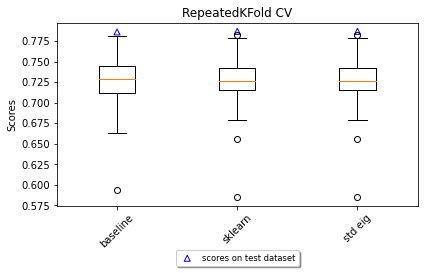

In [34]:
# visualize model evaluation
viz_labels = ['baseline', 'sklearn', 'std eig']

fig, ax = plt.subplots()

ax.boxplot(
    [
        cv_scores_baseline, 
        cv_scores_sklearn, 
        cv_scores_std_eig
    ], 
    labels=viz_labels
)
ax.scatter(
    [1, 2, 3], 
    [
        pipeline_baseline.score(X_test, Y_test), 
        eval_score_sklearn, 
        eval_score_std_eig
    ], 
    fc='none',
    ec='blue', 
    marker='^', 
    label='scores on test dataset'
)

ax.set(ylabel='Scores', title='RepeatedKFold CV')
ax.set_xticklabels(viz_labels, rotation=45)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.22),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize='small'
)

plt.tight_layout()